# TPCAV detailed usage

This tutorial goes through the detailed steps of TPCAV, make sure you installed tpcav package first:

`pip install tpcav`

In [1]:
# data download
!mkdir data/
!wget https://hgdownload.gi.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -P data/
!gunzip data/hg38.fa.gz
!wget https://raw.githubusercontent.com/seqcode/TPCAV/main/data/motif-clustering-v2.1beta_consensus_pwms.test.meme -P data/

import pyfaidx
pyfaidx.Fasta('data/hg38.fa')

mkdir: cannot create directory ‘data/’: File exists
--2026-02-06 15:38:02--  https://hgdownload.gi.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.gi.ucsc.edu (hgdownload.gi.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.gi.ucsc.edu (hgdownload.gi.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘data/hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M  38.0MB/s    in 26s     

2026-02-06 15:38:29 (36.3 MB/s) - ‘data/hg38.fa.gz’ saved [983659424/983659424]

gzip: data/hg38.fa already exists; do you wish to overwrite (y or n)? ^C
--2026-02-06 15:45:30--  https://raw.githubusercontent.com/seqcode/TPCAV/main/data/motif-clustering-v2.1beta_consensus_pwms.test.meme
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

Fasta("data/hg38.fa")

Since TPCAV is a concept based attribution method, the first step is to construct candidate concepts for testing, each concept is a set of input examples that share a similar pattern (e.g. motif).

Assume we start with a dummy model that has two linear layers taking 1024bp long one-hot coded DNA input for predicting a scalar value.

In [3]:
import torch

class DummyModelSeq(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1024, 1)
        self.layer2 = torch.nn.Linear(4, 1)

    def forward(self, seq):
        y_hat = self.layer1(seq)
        y_hat = y_hat.squeeze(-1)
        y_hat = self.layer2(y_hat)
        return y_hat

Now we start constructing concepts, a concept is basically an iterator of the inputs that represent a prominent pattern. TPCAV provides a class `ConceptBuilder` to construct common concepts in genomics field, here we use it to construct motif concepts, defined as sets of random genomic sequences inserted by motif instances.

There are 5 motif concepts built in this case given the test meme file

In [4]:
from pathlib import Path
from tpcav.concepts import ConceptBuilder

motif_path = Path("data") / "motif-clustering-v2.1beta_consensus_pwms.test.meme"

# create concept builder to generate concepts
builder = ConceptBuilder(
    genome_fasta="data/hg38.fa",
    input_window_length=1024,
    bws=None,
    num_motifs=12,
    include_reverse_complement=True,
    min_samples=1000,
    batch_size=8,
)
# use random regions as control  
builder.build_control()
# use meme motif PWMs to build motif concepts, one concept per motif
builder.add_meme_motif_concepts(str(motif_path))

/home/jmy5455/miniforge3/envs/test/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(Concept(1, 'AC0001:GATA-PROP:GATA'),
  Concept(2, 'AC0001:GATA-PROP:GATA_perm')),
 (Concept(3, 'AC0002:PROP-ALX:Homeodomain'),
  Concept(4, 'AC0002:PROP-ALX:Homeodomain_perm')),
 (Concept(5, 'AC0003:HNF1A-HNF1B:Homeodomain'),
  Concept(6, 'AC0003:HNF1A-HNF1B:Homeodomain_perm')),
 (Concept(7, 'AC0004:ZSCAN:C2H2_ZF'), Concept(8, 'AC0004:ZSCAN:C2H2_ZF_perm')),
 (Concept(9, 'AC0005:POU3F-POU1F:Homeodomain,POU'),
  Concept(10, 'AC0005:POU3F-POU1F:Homeodomain,POU_perm'))]

Concept constructed by `ConceptBuilder` contains an iterator of two things: fasta sequences strings and array of bigwig signal tracks. If your model takes different formats of inputs, you can provide a transformation function to fit your model. Below is the example of obtaining one hot coded DNA sequence inputs.

In [5]:
# each batch is a tuple of a fasta sequence list and an array of bigwig signals
next(iter(builder.concepts[0].data_iter))

/home/jmy5455/miniforge3/envs/test/lib/python3.14/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(['ATTTTACTAACTGCCACACTGCATAGCTTTTCTAGGGCTGTGGTTAGATTTACGGGAGAGAGGCACCAGAGTGGATTACAACACAGGACTGACCTTTTACCACCCGGCTGAAGCTCGAAAAACAAAACCAAATCCCATCTTACTAACCATACCTGCGTCTTTTCTGGGGTAATCGAGTTATTACAAGTTTGTTTGTTTTTTAAGATGGTTTTCCTTCCCTGAGAGAACAAATAATGGTCTTACGTCAATAAAGTTCTCGTAATGTAGTTATATTTTGCCTCCTAATACCGTTAGTGAGGCCTTTTCCCCCCTTTCTTCTCGAACATACATCAAGTGCCTTAGATCACGGTATAAGCACGTTATGTTATGCCATTTTAATCTCATAAATATGAAAATAAAAGACATAATCAGAGCAAAAACAGGACTTTTTATTTTTAAACCAAAGGAAGCCAAAATAGCAACAGAGAAGAAAGGAAATTTCAGTGCATTATCTCTGGGGCCAAGGTGCATTTGCCCTAGTTCTTTTTTTAATAACCTCCTTATTTTTCTTCCTCCCCATTCCACAGCACTCAGCATCTTCTATCTTGTCTCCCTTGGTGTAGCTCTAGTGTTCTAATTCTATCCCATCTTCTTCTACTGAAATAATGAACTTTTTAAAGAGAAAATTAAGTGAATGTCTTTGTAGCAATGAACCTCCCCCTCTCGAGAATAAAATAACGAACTTATGATAAGGCAATGCTTAACCCAGTGAACGAATTGCTTACATAATATCATTATTCAGGTGGGGCCATAATGACATTATTGACTCTGCCTACTGATATCGGCCATGTTAAGAATAATAGCTAATATATACTCAACATCTATTACCTGGCTTATATGTTAGCTTGTTTCTATTTTATAACAGCCCTGAAATGTAAAATGGTTTTATTTTATTTATTTATAATGGTATTATTCTTTTTTTGAGACGGAGTCTCGCCCTGTCGCCCAGGCTGGAGTG

In [6]:
from tpcav import helper

# apply transformation function to obtain one-hot encoded sequences
def transform_fasta_to_one_hot_seq(seq, chrom):
    # `seq` is a list of fasta sequences
    # `chrom` is a numpy array of bigwig signals of shape [-1, # bigwigs, len]
    return (helper.fasta_to_one_hot_sequences(seq),) # it has to return a tuple of inputs, even if there is only one input
builder.apply_transform(transform_fasta_to_one_hot_seq)

In [7]:
# after transformation each batch is one-hot coded DNA arrays wrapped in tuple
next(iter(builder.concepts[0].data_iter))

(tensor([[[1., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.]],
 
         [[1., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 1., 0., 1.]],
 
         ...,
 
         [[0., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
   

After concept construction, now it's time to train the linear classifier for every concept in your model. You need to wrap your model instance by `TPCAV` class with the name of the layer for interpretation provided, then we apply PCA transformation given the concepts we just built to decorrelate the embedding space to solve the correlated redundant feature issue.

In [8]:
from tpcav.tpcav_model import TPCAV
# create TPCAV model on top of your model
tpcav_model = TPCAV(DummyModelSeq(), layer_name="layer1")
# fit PCA on sampled all concept activations
tpcav_model.fit_pca(
    concepts=builder.all_concepts(),
    num_samples_per_concept=10,
    num_pc="full",
)
# you can save the tpcav model in case of future use
torch.save(tpcav_model, "data/tmp_tpcav_model.pt")

INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0001:GATA-PROP:GATA
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0002:PROP-ALX:Homeodomain
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0003:HNF1A-HNF1B:Homeodomain
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0004:ZSCAN:C2H2_ZF
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0005:POU3F-POU1F:Homeodomain,POU
INFO:tpcav.tpcav_model:Sampled 10 activations from concept random_regions
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0001:GATA-PROP:GATA_perm
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0002:PROP-ALX:Homeodomain_perm
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0003:HNF1A-HNF1B:Homeodomain_perm
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0004:ZSCAN:C2H2_ZF_perm
INFO:tpcav.tpcav_model:Sampled 10 activations from concept AC0005:POU3F-POU1F:Homeodomain,POU_perm


In [10]:
# now tpcav_model contains the necessary parameters for PCA transformation
tpcav_model.Vh

tensor([[-0.5561,  0.5143, -0.3964,  0.5187],
        [-0.4904,  0.3712,  0.7034, -0.3563],
        [-0.2944, -0.6055,  0.4219,  0.6072],
        [ 0.6029,  0.4806,  0.4125,  0.4851]])

Using the fitted TPCAV model, we can train the concept activation vectors (CAVs) on the concepts we built

In [11]:
from tpcav.cavs import CavTrainer

# create trainer for computing CAVs
cav_trainer = CavTrainer(tpcav_model, penalty="l2")
# set control concept for CAV training
cav_trainer.set_control(builder.control_concepts[0], num_samples=100)
# train CAVs for all concepts
cav_trainer.train_concepts(
    builder.concepts, 100, output_dir="data/cavs/", num_processes=2
)

INFO:tpcav.cavs:Submitted CAV training for concept AC0001:GATA-PROP:GATA
INFO:tpcav.cavs:Submitted CAV training for concept AC0002:PROP-ALX:Homeodomain
INFO:tpcav.cavs:Submitted CAV training for concept AC0003:HNF1A-HNF1B:Homeodomain
INFO:tpcav.cavs:Submitted CAV training for concept AC0004:ZSCAN:C2H2_ZF
INFO:tpcav.cavs:Submitted CAV training for concept AC0005:POU3F-POU1F:Homeodomain,POU
INFO:tpcav.cavs:Best Params: {'alpha': 0.0001} | Iterations: 26
INFO:tpcav.cavs:[train] Accuracy: 0.5563
INFO:tpcav.cavs:[val] Accuracy: 0.4500
INFO:tpcav.cavs:[test] Accuracy: 0.3500
INFO:tpcav.cavs:Best Params: {'alpha': 0.0001} | Iterations: 30
INFO:tpcav.cavs:[train] Accuracy: 0.5437
INFO:tpcav.cavs:[val] Accuracy: 0.4500
INFO:tpcav.cavs:[test] Accuracy: 0.5500
INFO:tpcav.cavs:Best Params: {'alpha': 1.0} | Iterations: 23
/home/jmy5455/miniforge3/envs/test/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due 

In [12]:
# after training, the cavs are stored
cav_trainer.cav_weights

{'AC0001:GATA-PROP:GATA': tensor([-9.3131e-01, -6.6705e-01, -3.0922e-01, -9.7687e+00,  1.2593e-05,
         -4.3571e-06,  2.0111e-05, -8.0006e-06]),
 'AC0002:PROP-ALX:Homeodomain': tensor([ 1.6687e-01,  2.0621e+00, -1.2292e+00, -9.8039e+00,  5.1806e-07,
         -5.5115e-06,  1.1973e-05, -2.0196e-05]),
 'AC0003:HNF1A-HNF1B:Homeodomain': tensor([-1.1578e-02,  1.4068e-02,  1.0209e-01, -2.3463e-02,  2.9325e-09,
         -2.4215e-08, -1.0281e-08,  1.0156e-08]),
 'AC0004:ZSCAN:C2H2_ZF': tensor([ 4.6019e-02,  4.2294e-01, -8.6205e-01, -1.0658e+01,  3.2717e-06,
         -1.4539e-05,  4.1489e-05,  1.5923e-06]),
 'AC0005:POU3F-POU1F:Homeodomain,POU': tensor([ 5.1151e-01,  1.2087e+00, -4.2905e-01, -1.0862e+01, -1.2512e-05,
         -1.9252e-05,  1.4986e-05, -1.4021e-05])}

Finally, we can compute the layer attribution scores on the test regions against control regions, and obtain the final TPCAV score for each concept

In [13]:
# create input regions and baseline regions for attribution
random_regions_1 = helper.random_regions_dataframe(
    "data/hg38.fa.fai", 1024, 100, seed=1
)
random_regions_2 = helper.random_regions_dataframe(
    "data/hg38.fa.fai", 1024, 100, seed=2
)
# create iterators to yield one-hot encoded sequences from the region dataframes
def pack_data_iters(df):
    seq_fasta_iter = helper.dataframe_to_fasta_iter(
        df, "data/hg38.fa", batch_size=8
    )
    seq_one_hot_iter = (
        helper.fasta_to_one_hot_sequences(seq_fasta)
        for seq_fasta in seq_fasta_iter
    )
    return zip(seq_one_hot_iter, )
# compute layer attributions given the iterators of testing regions and control regions
attributions = tpcav_model.layer_attributions(
    pack_data_iters(random_regions_1), pack_data_iters(random_regions_2)
)["attributions"]
# compute TPCAV scores for the concept
cav_trainer.tpcav_score_all_concepts_log_ratio(attributions)

/home/jmy5455/miniforge3/envs/test/lib/python3.14/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/jmy5455/miniforge3/envs/test/lib/python3.14/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


{'AC0001:GATA-PROP:GATA': 3.912023005428146,
 'AC0002:PROP-ALX:Homeodomain': 4.61512051684126,
 'AC0003:HNF1A-HNF1B:Homeodomain': -2.9652730660692823,
 'AC0004:ZSCAN:C2H2_ZF': 4.61512051684126,
 'AC0005:POU3F-POU1F:Homeodomain,POU': 4.61512051684126}

You can also visualize the cosine similarity matrix between concepts vectors combined with the TPCAV scores

INFO:tpcav.cavs:Skipping CAV AC0003:HNF1A-HNF1B:Homeodomain with F-score 0.000 below threshold 0.100


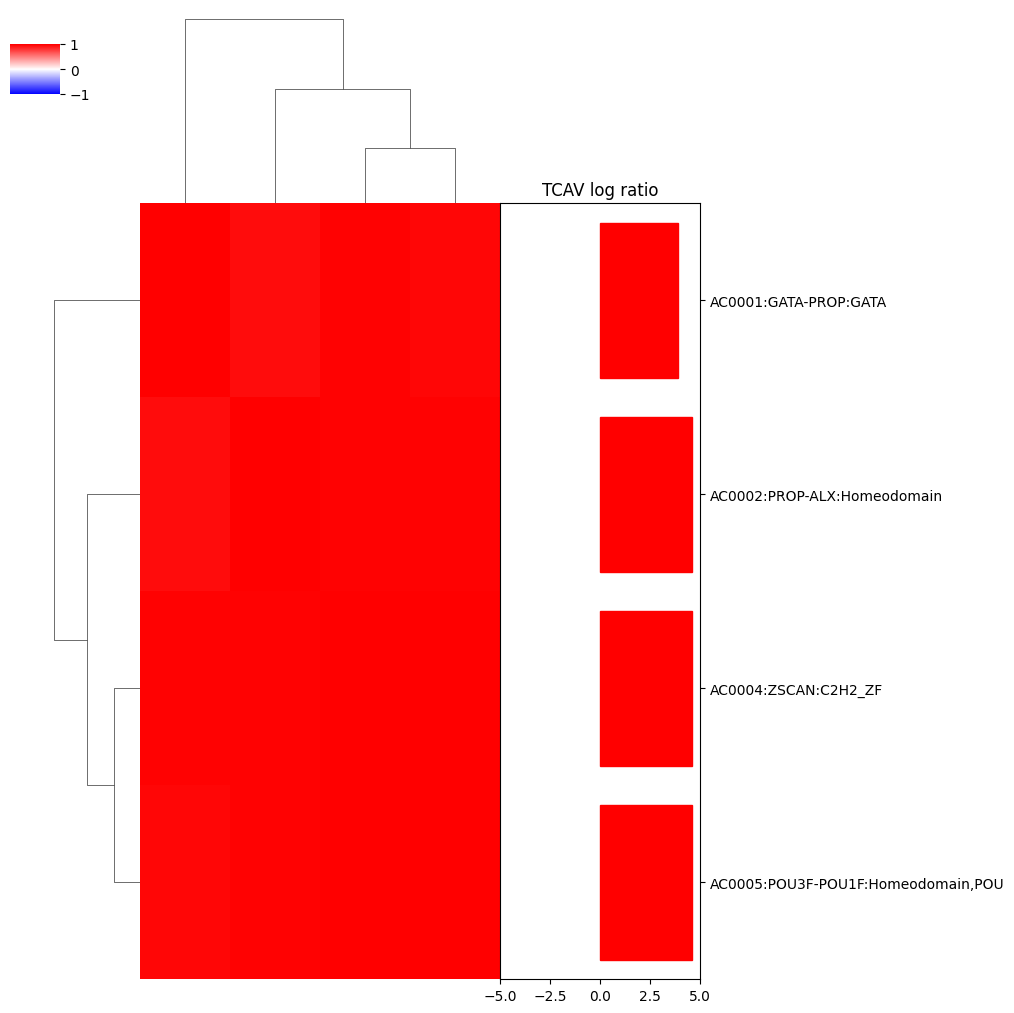

In [17]:
cav_trainer.plot_cavs_similaritiy_heatmap(attributions, fscore_thresh=0.1)